In [1]:
import pydoocs as doo
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.optimize import curve_fit
from PIL import Image
import os
import time

In [2]:
def cathodeLaserSwitch(setto,address="SINBAD.DIAG/TIMER.CENTRAL/MASTER/EVENT5"):
    #sets the bool switch of the cathode laser event to setto and waits a sec
    bits=doo.read(address)["data"]
    if setto: bits[0] = 1
    else: bits[0] = 0
    doo.write(address,bits)
    time.sleep(3)

def setSteerer(current=5,uc=0.1,wt=0.5,SP="SINBAD.MAGNETS/MAGNET.ML/ARLIMCHG3/CURRENT.SP",RBV="SINBAD.MAGNETS/MAGNET.ML/ARLIMCHG3/CURRENT.RBV"):
    #sets steerer setpoint SP to current in ampere and reads from RBV until 
    #the value is in interval uc in ampere around current for the watiting time wt in seconds
    doo.write(SP,current)
    blub=False
    while blub==False:
        rc=doo.read(RBV)["data"]
        if rc < current+uc/2 and rc > current-uc/2:
            time.sleep(wt)
            if rc < current+uc and rc > current-uc  : blub=True
        else:
            time.sleep(wt)

def takeImages(N=10,address="SINBAD.DIAG/CAMERA/AR.LI.BSC.X.1/IMAGE_EXT",suffix=""):
    #returns list of [data array,macropulse number] of length N from address
    Ims = []
    for  i in np.arange(0,N,1):
        ImTest = doo.read(address)
        #buff = Image.fromarray(ImTest["data"])
        #buff.save(f"20210414_AAtest/MRR1_{i:02d}"+suffix+".tif")
        Ims.append([ImTest["data"],ImTest["macropulse"]])
        time.sleep(0.1)
    return Ims

def FWHM(x, y):
        def half_max_x(x, y):
            def lin_interp(x, y, i, half):
                return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))
            half = max(y)/2.0
            signs = np.sign(np.add(y, -half))
            zero_crossings = (signs[0:-2] != signs[1:-1])
            zero_crossings_i = np.where(zero_crossings)[0]
            return [lin_interp(x, y, zero_crossings_i[0], half),
                    lin_interp(x, y, zero_crossings_i[1], half)]
        try:
            hmx = half_max_x(x,y)
            return hmx[1] - hmx[0]
        except Exception as e:
            return 0.00001

def gaussian(x,A,mu,sigma):
    return np.abs(A) * np.exp(-((x-mu)/sigma)**2/2)
#to save all the values for plotting
values=[]

In [7]:
adrScr='SINBAD.DIAG/CAMERA/AR.BC.BSC.E.1'
NImages=10
#read the vertical binning
xBinning=doo.read(adrScr+"/BINNINGVERTICAL")["data"]
yBinning=doo.read(adrScr+"/BINNINGHORIZONTAL")["data"]
#read the pixel scaling factor
xScale=doo.read(adrScr+"/X.POLY_SCALE")["data"][2]*(1e0); print('x Pixel scaling factor for ' + adrScr + ': ' + str(xScale) + ' mm')
yScale=doo.read(adrScr+"/Y.POLY_SCALE")["data"][2]*(1e0); print('y Pixel scaling factor for ' + adrScr + ': ' + str(yScale) + ' mm')

#get the image data
print('Working...')
cathodeLaserSwitch(setto=True)
beam1=takeImages(N=NImages, address=adrScr+"/IMAGE_EXT",suffix='beam')
cathodeLaserSwitch(setto=False)
back1=takeImages(N=NImages, address=adrScr+"/IMAGE_EXT",suffix='back')
cathodeLaserSwitch(setto=True)

back1 = np.array(back1)[:,0]
beam1 = np.array(beam1)[:,0]

#averaged images
beamAv1 = np.sum(beam1)/beam1.size

backAv1 = np.sum(back1)/back1.size

#projX = np.sum(ndimage.gaussian_filter(beamAv1-backAv1,sigma=3),0)
#projY = np.sum(ndimage.gaussian_filter(beamAv1-backAv1,sigma=3),1)
projX = np.sum(beamAv1-backAv1,0)
projY = np.sum(beamAv1-backAv1,1)

#intensity cut
minIntensity=400000
#projX[np.where(projX<minIntensity)]=0
#projY[np.where(projY<minIntensity)]=0

xcentralPixel = doo.read(adrScr+"/SENSORWIDTH")["data"]/xBinning/2
ycentralPixel = doo.read(adrScr+"/SENSORHEIGHT")["data"]/yBinning/2


xPos = np.linspace(0,len(projX),len(projX)) - xcentralPixel
xPosmm = xPos * xScale * xBinning
yPos = np.linspace(0,len(projY),len(projY)) - ycentralPixel
yPosmm = yPos * yScale * yBinning

xMean = np.average(xPosmm, weights=projX)
xRMS = np.sqrt(np.abs(np.average((xPosmm-xMean)**2, weights=projX)))
yMean = np.average(yPosmm, weights=projY)
yRMS = np.sqrt(np.abs(np.average((yPosmm-yMean)**2, weights=projY)))

print('DONE!')

x Pixel scaling factor for SINBAD.DIAG/CAMERA/AR.BC.BSC.E.1: 0.013989999890327454 mm
y Pixel scaling factor for SINBAD.DIAG/CAMERA/AR.BC.BSC.E.1: 0.01119999960064888 mm
Working...
DONE!


Mean: -0.563 mm, std: 4.307 mm, gaussian fitted std: 0.247 mm,FWHM: 0.139 mm


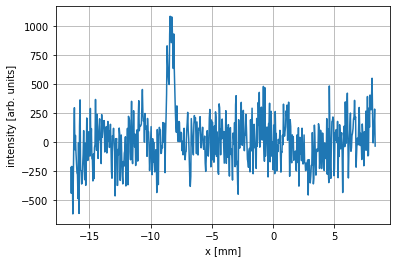

In [37]:
plt.plot(xPosmm,projX)
xpopt,xpcov=curve_fit(gaussian,xPosmm,projX,maxfev=10000)

#plt.title('Mean: '+ '{:.3f}'.format(xMean) + ' mm, std: '+ '{:.3f}'.format(xRMS) +' mm,FWHM: '+'{:.3f}'.format(abs(FWHM(xPosmm,projX))) +' mm')
print('Mean: '+ '{:.3f}'.format(xMean) + ' mm, std: '+ '{:.3f}'.format(xRMS) + ' mm, gaussian fitted std: '+
      '{:.3f}'.format(abs(xpopt[2])) +' mm,FWHM: ' + '{:.3f}'.format(abs(FWHM(xPosmm,projX))) +' mm')
plt.ylabel('intensity [arb. units]')
plt.xlabel('x [mm]')
#plt.xlim(-1,1)
plt.grid()
plt.show()

Mean: 15.826 mm, std: 12.860 mm, gaussian fitted std: 0.192 mm,FWHM: 0.490 mm


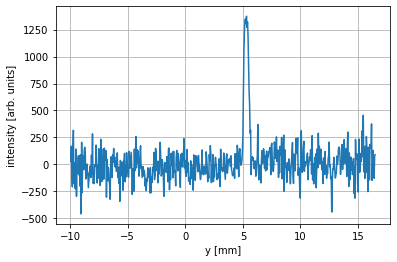

In [38]:
plt.plot(yPosmm,projY)
ypopt,ypcov=curve_fit(gaussian,yPosmm,projY,maxfev=10000)

#plt.title('Mean: '+ '{:.3f}'.format(yMean) + ' mm, std: '+ '{:.3f}'.format(yRMS) +' mm,FWHM: '+'{:.3f}'.format(abs(FWHM(yPosmm,projY))) +' mm')
print('Mean: '+ '{:.3f}'.format(yMean) + ' mm, std: '+ '{:.3f}'.format(yRMS) + ' mm, gaussian fitted std: '+
      '{:.3f}'.format(abs(ypopt[2])) +' mm,FWHM: ' + '{:.3f}'.format(abs(FWHM(yPosmm,projY))) +' mm')
plt.ylabel('intensity [arb. units]')
plt.xlabel('y [mm]')
plt.grid()
#plt.xlim(-2,-1)
plt.show()

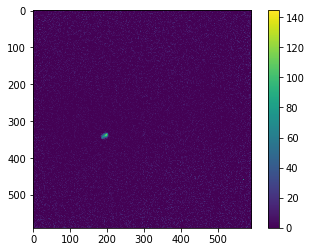

In [10]:
plt.imshow(beamAv1-backAv1,vmin=0)#,vmax=2000)
plt.colorbar()
#plt.grid()
#plt.savefig('20210121SHR1_3.pdf')
plt.show()

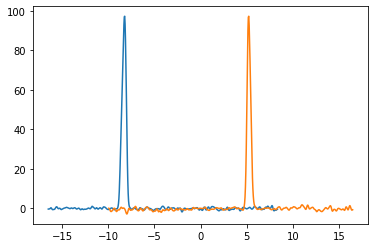

In [25]:
Im=ndimage.gaussian_filter(beamAv1-backAv1,sigma=2)
#Im=beamAv1-backAv1
Ymaxcut=Im[:,np.where(Im==np.max(Im))[1]].flatten()
Xmaxcut=Im[np.where(Im==np.max(Im))[0],:].flatten()
plt.plot(xPosmm,Xmaxcut)
plt.plot(yPosmm,Ymaxcut)
#plt.xlim(-2,1)
plt.show()

In [33]:
xpopt,xpcov=curve_fit(gaussian,xPosmm,Xmaxcut
                      ,maxfev=4000,p0=[100,-8,0.2])

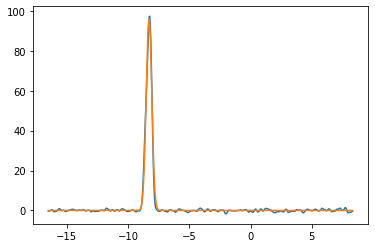

In [34]:
#dgfit = doublegaussiansum(xPosmm,*[1500,850,0.1,0.3,0.8,0.1])
dgfit = gaussian(xPosmm,*xpopt)

plt.plot(xPosmm,Xmaxcut)
plt.plot(xPosmm,dgfit)
plt.show()

In [35]:
ypopt,ypcov=curve_fit(gaussian,yPosmm,Ymaxcut,maxfev=4000)#,p0=xpopt)

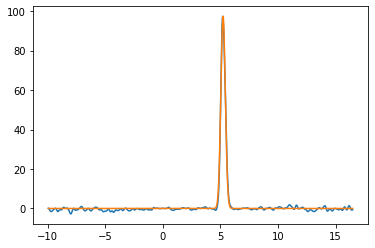

In [36]:
#dgfit = doublegaussiansum(xPosmm,*[1500,850,0.1,0.3,0.8,0.1])
dgfity = gaussian(yPosmm,*ypopt)

plt.plot(yPosmm,Ymaxcut)
plt.plot(yPosmm,dgfity)
plt.show()

In [22]:
xpopt

array([1.04249827, 1.3254675 , 0.1388112 ])

In [23]:
ypopt

array([97.56126761,  5.23427481,  0.19290444])

In [214]:
phase = doo.read('SINBAD.RF/LLRF.CONTROLLER/VS.AR.LI.RSB.L.1/PHASE.SAMPLE')['data']
first=np.genfromtxt('secondPhaseScanTWS120210407.txt')
values.append([xMean,yMean,xRMS,yRMS,phase])

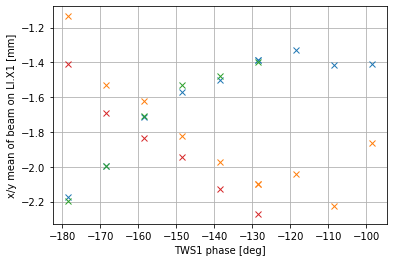

In [215]:
arrValues= np.array(values)
plt.errorbar(arrValues[:,4],arrValues[:,0],marker='x',label='x',capsize=5,linestyle=' ')
plt.errorbar(arrValues[:,4],arrValues[:,1],marker='x',label='y',capsize=5,linestyle=' ')
plt.errorbar(first[:,4],first[:,0],marker='x',label='x',capsize=5,linestyle=' ')
plt.errorbar(first[:,4],first[:,1],marker='x',label='y',capsize=5,linestyle=' ')
plt.ylabel('x/y mean of beam on LI.X1 [mm]')
plt.xlabel('TWS1 phase [deg]')
#plt.legend()
plt.grid()
#plt.savefig('LIR2vsTWS1phase1.pdf')
plt.show()

In [216]:
np.savetxt('thirdPhaseScanTWS120210407.txt',arrValues,header='xMean zMean xRMS(Beamsize) yRMS(Beamsize) TWS1phase')

In [163]:
first=np.genfromtxt('firstPhaseScanTWS120210407.txt')

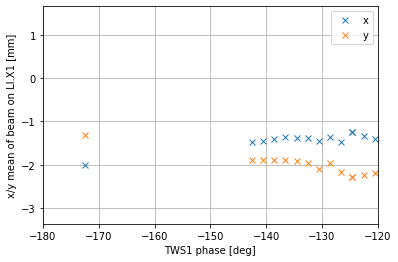

In [170]:
plt.errorbar(first[:,4],first[:,0],marker='x',label='x',capsize=5,linestyle=' ')
plt.errorbar(first[:,4],first[:,1],marker='x',label='y',capsize=5,linestyle=' ')
plt.ylabel('x/y mean of beam on LI.X1 [mm]')
plt.xlabel('TWS1 phase [deg]')
plt.xlim(-180,-120)
plt.legend()
plt.grid()
#plt.savefig('LIR2vsTWS1phase1.pdf')
plt.show()